In [1]:
from sklearn.datasets import make_circles

nSamples = 1000

X, y = make_circles(nSamples, noise=0.03, random_state=6969)

X[:5], y[:5]

(array([[ 0.75872768, -0.71282609],
        [ 0.5539817 ,  0.88710532],
        [-0.53698537, -0.84957689],
        [ 0.99584864,  0.28079807],
        [ 0.63369659, -0.77541305]]),
 array([0, 0, 0, 0, 0]))

In [2]:
import pandas as pd

circles = pd.DataFrame(
    {
        "X1"    : X[:, 0],
        "X2"    : X[:, 1],
        "label" : y
    }
)

circles.head(10)

,X1,X2,label
0,0.758728,-0.712826,0
1,0.553982,0.887105,0
2,-0.536985,-0.849577,0
3,0.995849,0.280798,0
4,0.633697,-0.775413,0
5,-0.494333,0.867261,0
6,-0.403838,-0.685770,1
7,0.258003,0.747858,1
8,0.407970,-0.640493,1
9,0.873361,-0.600255,0


In [3]:
circles.label.value_counts()

0    500
1    500
Name: label, dtype: int64

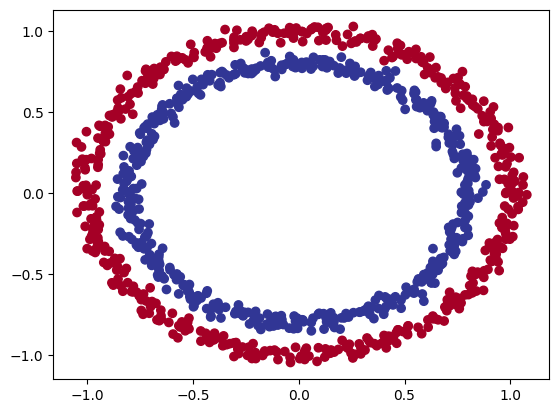

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7587, -0.7128],
         [ 0.5540,  0.8871],
         [-0.5370, -0.8496],
         [ 0.9958,  0.2808],
         [ 0.6337, -0.7754]]),
 tensor([0., 0., 0., 0., 0.]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=6969

)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model = CircleModel().to(device)

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [10]:
model.eval()
with torch.inference_mode():
  untrained_preds = model(X_test.to(device))
  print(untrained_preds[:10])
  print(y_test[:10])

tensor([[ 0.5995],
        [-0.0250],
        [-0.0822],
        [ 0.1009],
        [ 0.6058],
        [-0.1024],
        [ 0.0268],
        [-0.1469],
        [-0.1353],
        [ 0.3012]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 0.])


In [11]:
lossFunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

def accuracyFunc(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

In [12]:
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[ 0.5995],
        [-0.0250],
        [-0.0822],
        [ 0.1009],
        [ 0.6058]], grad_fn=<SliceBackward0>)

In [13]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6455],
        [0.4938],
        [0.4795],
        [0.5252],
        [0.6470]], grad_fn=<SigmoidBackward0>)

In [14]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

y_preds.squeeze()

tensor([1., 0., 0., 1., 1.], grad_fn=<SqueezeBackward0>)

In [15]:
y_test[:5]

tensor([0., 1., 0., 0., 0.])

In [16]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = lossFunc(y_logits, y_train)
  accuracy = accuracyFunc(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    model.eval()

    with torch.inference_mode():
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = lossFunc(test_logits, y_test)
      test_acc = accuracyFunc(y_true=y_test, y_pred=test_pred)

      print(f"Epoch : {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}")

Epoch : 0 | Loss : 0.70984 | Accuracy : 51.25
Epoch : 100 | Loss : 0.70132 | Accuracy : 50.88
Epoch : 200 | Loss : 0.69747 | Accuracy : 50.38
Epoch : 300 | Loss : 0.69544 | Accuracy : 51.12
Epoch : 400 | Loss : 0.69429 | Accuracy : 50.38
Epoch : 500 | Loss : 0.69361 | Accuracy : 50.12
Epoch : 600 | Loss : 0.69321 | Accuracy : 50.75
Epoch : 700 | Loss : 0.69297 | Accuracy : 51.25
Epoch : 800 | Loss : 0.69283 | Accuracy : 50.88
Epoch : 900 | Loss : 0.69274 | Accuracy : 50.75


helper_functions.py already exists, skipping download


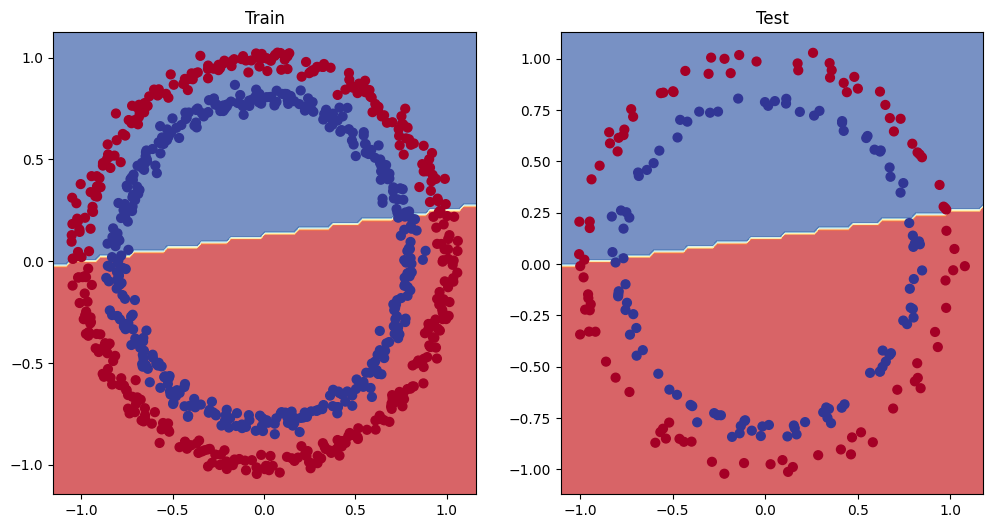

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [18]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [19]:
trainSize = int(0.8 * len(X_regression))

X_train_reg, y_train_reg = X_regression[:trainSize], y_regression[:trainSize]
X_test_reg, y_test_reg = X_regression[trainSize:], y_regression[trainSize:]

print(len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg))

80 80 20 20


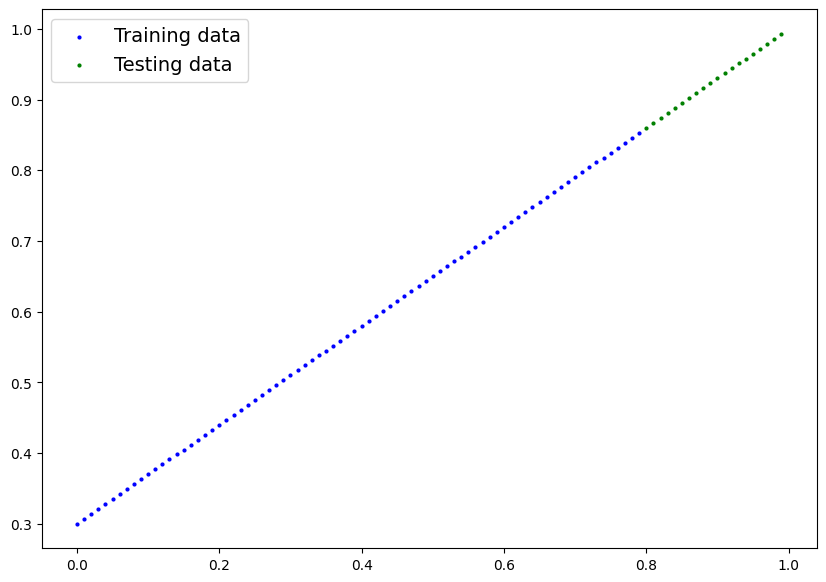

In [20]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

In [21]:
model_reg = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_reg

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
lossFunc_reg = nn.L1Loss()
optimizer_reg = torch.optim.SGD(model_reg.parameters(), lr=0.1)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  y_pred = model_reg(X_train_reg)

  loss = lossFunc_reg(y_pred, y_train_reg)

  optimizer_reg.zero_grad()
  loss.backward()
  optimizer_reg.step()

  if epoch % 100 == 0:
    model_reg.eval()

    with torch.inference_mode():
      test_pred = model_reg(X_test_reg)
      test_loss = lossFunc_reg(test_pred, y_test_reg)

      print(f"Epoch : {epoch} | Loss : {loss:.5f} | Test Loss {test_loss:.5f}")

Epoch : 0 | Loss : 0.49054 | Test Loss 0.57530
Epoch : 100 | Loss : 0.08616 | Test Loss 0.02413
Epoch : 200 | Loss : 0.06080 | Test Loss 0.00831
Epoch : 300 | Loss : 0.05696 | Test Loss 0.00687
Epoch : 400 | Loss : 0.05203 | Test Loss 0.00835
Epoch : 500 | Loss : 0.05851 | Test Loss 0.02179
Epoch : 600 | Loss : 0.04648 | Test Loss 0.01825
Epoch : 700 | Loss : 0.06429 | Test Loss 0.02001
Epoch : 800 | Loss : 0.07100 | Test Loss 0.01452
Epoch : 900 | Loss : 0.05441 | Test Loss 0.01108


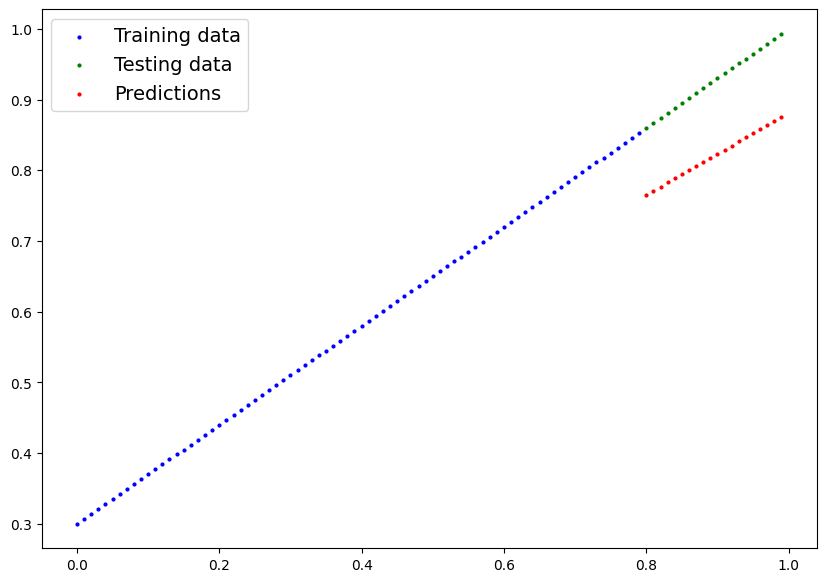

In [23]:
# Turn on evaluation mode
model_reg.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_reg(X_test_reg)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu());

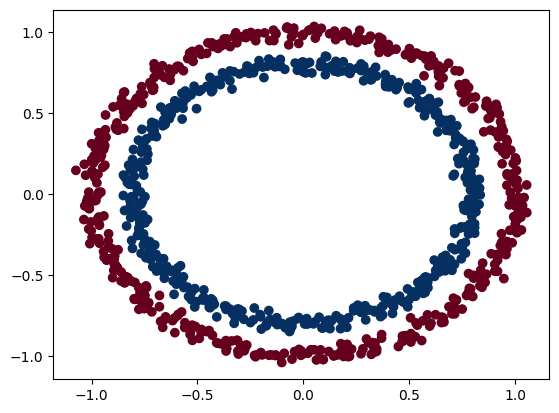

In [24]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=123)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [25]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

X_train[:5], y_train[:5]

(tensor([[ 0.7149, -0.7400],
         [ 0.0748, -0.7606],
         [ 0.1461, -0.9945],
         [-0.7351, -0.1578],
         [ 0.9209,  0.2904]]),
 tensor([0., 1., 0., 1., 0.]))

In [26]:
from torch import nn

class CircleModelNonLinear(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_non = CircleModelNonLinear().to(device)
model_non

CircleModelNonLinear(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
lossFunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_non.parameters(), lr=0.1)

In [28]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_non.train()

  y_logits = model_non(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = lossFunc(y_logits, y_train)
  accuracy = accuracyFunc(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    model_non.eval()

    with torch.inference_mode():
      test_logits = model_non(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = lossFunc(test_logits, y_test)
      test_acc = accuracyFunc(y_true=y_test, y_pred=test_pred)

      print(f"Epoch : {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}")

Epoch : 0 | Loss : 0.70085 | Accuracy : 51.12
Epoch : 100 | Loss : 0.69032 | Accuracy : 51.12
Epoch : 200 | Loss : 0.68747 | Accuracy : 52.25
Epoch : 300 | Loss : 0.68387 | Accuracy : 67.50
Epoch : 400 | Loss : 0.67805 | Accuracy : 72.62
Epoch : 500 | Loss : 0.66840 | Accuracy : 73.38
Epoch : 600 | Loss : 0.65134 | Accuracy : 78.50
Epoch : 700 | Loss : 0.61913 | Accuracy : 84.75
Epoch : 800 | Loss : 0.56132 | Accuracy : 90.25
Epoch : 900 | Loss : 0.46496 | Accuracy : 95.75


In [29]:
model_non.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_non(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.]),
 tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0.]))

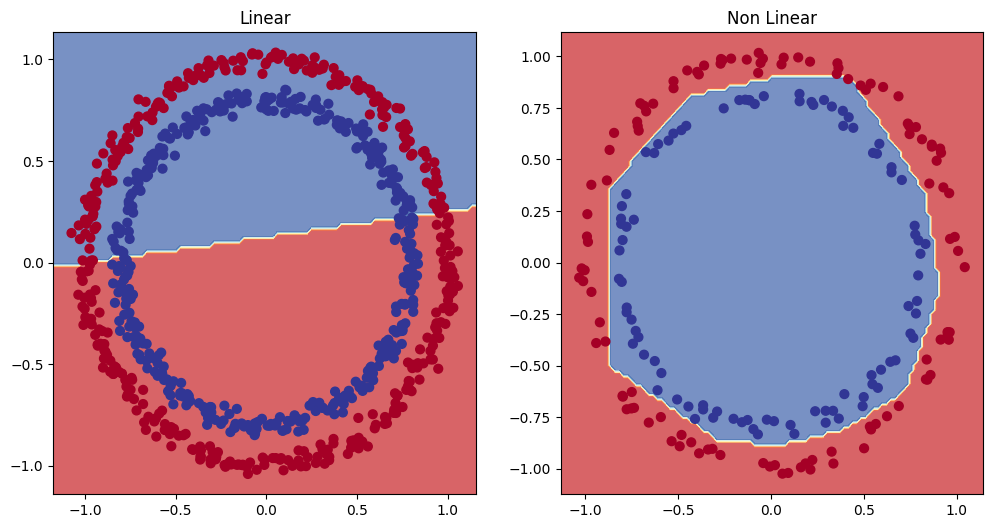

In [30]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Linear")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Non Linear")
plot_decision_boundary(model_non, X_test, y_test)

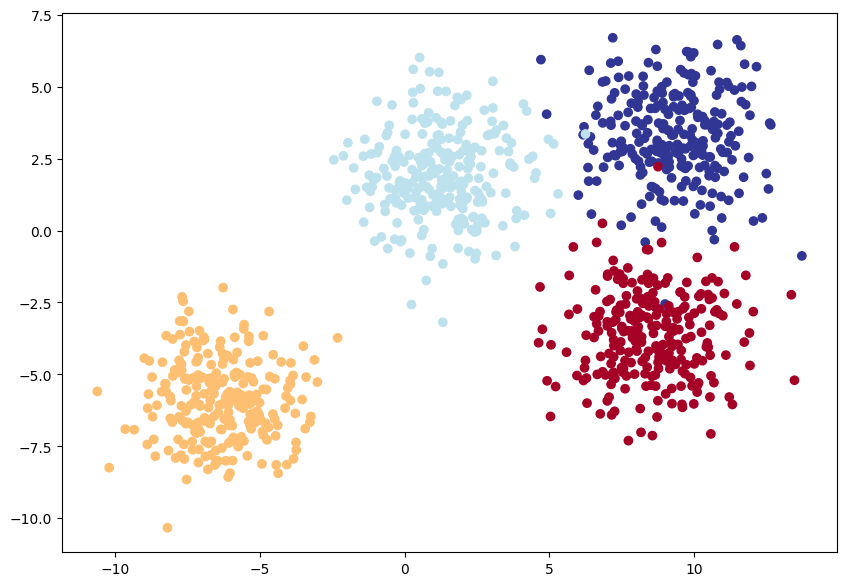

In [38]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE=12345

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state=RANDOM_STATE)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_STATE
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [58]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_blob = BlobModel(input_features=NUM_FEATURES,
                       output_features=NUM_CLASSES,
                       hidden_units=16).to(device)
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [59]:
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_blob.parameters(), lr=0.1)

In [60]:
model_blob(X_blob_train.to(device))[:5]

tensor([[ 0.6592, -0.2893,  0.5027, -0.3733],
        [-0.0027,  0.1415, -0.2268, -0.4926],
        [-0.2102, -0.0511, -0.0198, -0.5448],
        [ 0.7826, -0.2336,  0.6413, -0.3060],
        [ 1.1196, -0.2560,  0.9339, -0.2739]], grad_fn=<SliceBackward0>)

In [61]:
model_blob(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [62]:
y_logits = model_blob(X_blob_train.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.6592, -0.2893,  0.5027, -0.3733],
        [-0.0027,  0.1415, -0.2268, -0.4926],
        [-0.2102, -0.0511, -0.0198, -0.5448],
        [ 0.7826, -0.2336,  0.6413, -0.3060],
        [ 1.1196, -0.2560,  0.9339, -0.2739]], grad_fn=<SliceBackward0>)
tensor([[0.3848, 0.1491, 0.3291, 0.1370],
        [0.2804, 0.3238, 0.2241, 0.1718],
        [0.2440, 0.2861, 0.2952, 0.1746],
        [0.3896, 0.1410, 0.3382, 0.1312],
        [0.4289, 0.1084, 0.3562, 0.1065]], grad_fn=<SliceBackward0>)


In [63]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 200

for epoch in range(epochs):
  model_blob.train()

  y_logits = model_blob(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = lossFunc(y_logits, y_blob_train)
  accuracy = accuracyFunc(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_blob.eval()

  with torch.inference_mode():
    test_logits = model_blob(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = lossFunc(test_logits, y_blob_test)
    test_accuracy = accuracyFunc(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 1.72247, Acc: 0.38% | Test Loss: 1.14628, Test Acc: 45.00%
Epoch: 10 | Loss: 0.57405, Acc: 89.75% | Test Loss: 0.57444, Test Acc: 88.50%
Epoch: 20 | Loss: 0.32446, Acc: 94.50% | Test Loss: 0.34707, Test Acc: 92.00%
Epoch: 30 | Loss: 0.22415, Acc: 96.50% | Test Loss: 0.25644, Test Acc: 93.50%
Epoch: 40 | Loss: 0.17761, Acc: 97.00% | Test Loss: 0.21471, Test Acc: 94.50%
Epoch: 50 | Loss: 0.15046, Acc: 96.88% | Test Loss: 0.19122, Test Acc: 96.00%
Epoch: 60 | Loss: 0.13206, Acc: 97.00% | Test Loss: 0.17607, Test Acc: 96.00%
Epoch: 70 | Loss: 0.11831, Acc: 97.00% | Test Loss: 0.16530, Test Acc: 96.00%
Epoch: 80 | Loss: 0.10724, Acc: 97.12% | Test Loss: 0.15716, Test Acc: 97.00%
Epoch: 90 | Loss: 0.09813, Acc: 97.25% | Test Loss: 0.15074, Test Acc: 97.00%
Epoch: 100 | Loss: 0.09048, Acc: 97.62% | Test Loss: 0.14557, Test Acc: 97.00%
Epoch: 110 | Loss: 0.08393, Acc: 97.75% | Test Loss: 0.14127, Test Acc: 97.00%
Epoch: 120 | Loss: 0.07827, Acc: 97.88% | Test Loss: 0.13770, Te

In [64]:
model_blob.eval()
with torch.inference_mode():
  y_logits = model_blob(X_blob_test)

y_logits[:10]

tensor([[ -1.5706,  -7.4436,   3.0242,   6.7551],
        [ -2.5406,  -1.3043,   4.5530,  -0.2759],
        [ -2.0925, -10.0194,   3.2654,   9.9394],
        [ -4.0147,   6.8287,  -0.4426,  -4.1340],
        [ -3.4123,   6.2979,  -0.4411,  -3.9098],
        [ -4.0363,   7.6803,  -0.7991,  -4.5622],
        [  7.3643,  -6.2886,  -1.6354,   0.4876],
        [  6.1945,  -4.9456,  -1.1812,  -0.2928],
        [  1.8893,  -7.7009,   0.9201,   5.1852],
        [ -3.2314,   6.2196,  -0.4538,  -3.8828]])

In [65]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

y_blob_test[:10], y_preds[:10]

(tensor([3, 2, 3, 1, 1, 1, 0, 0, 3, 1]),
 tensor([3, 2, 3, 1, 1, 1, 0, 0, 3, 1]))

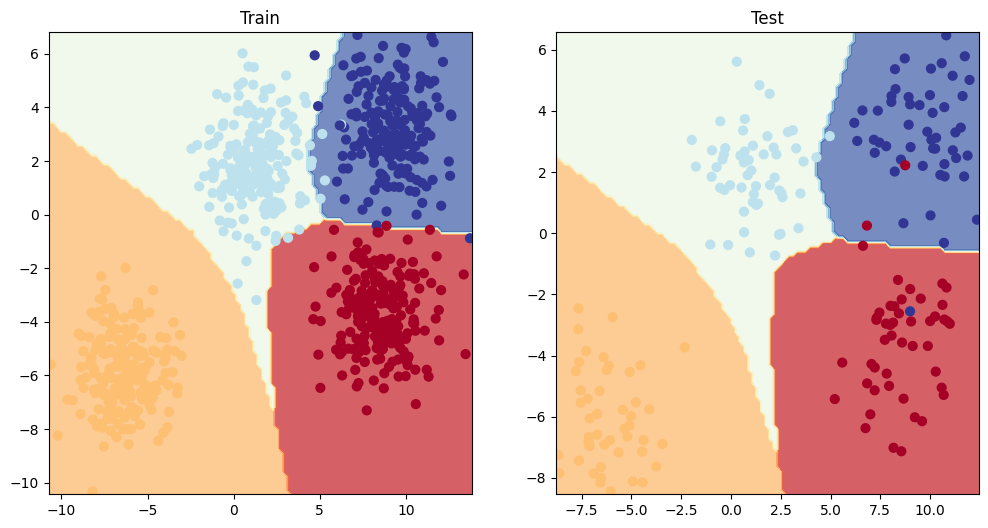

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)

# **EXERCISE**

In [75]:
import torch
from torch import nn
from sklearn.datasets import make_moons

N_SAMPLES = 1000
RANDOM_STATE = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

X, y = make_moons(n_samples=N_SAMPLES, random_state=RANDOM_STATE)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [84]:
model_moon = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.Linear(in_features=16, out_features=1)
).to(device)

model_moon

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Linear(in_features=16, out_features=1, bias=True)
)

In [85]:
lossFunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_moon.parameters(), lr=0.1)

In [86]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 700

for epoch in range(epochs):
  model_moon.train()

  y_logits = model_moon(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = lossFunc(y_logits, y_train)
  accuracy = accuracyFunc(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_moon.eval()
  with torch.inference_mode():
    test_logits = model_moon(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = lossFunc(test_logits, y_test)
    test_accuracy = accuracyFunc(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss:.5f} | Train Accuracy {accuracy:.2f} | Test Loss {test_loss:.5f} | Test Accuracy {test_accuracy:.2f}")

Epoch 0 | Train Loss 0.719817042350769 | Train Accuracy 50.0 | Test Loss 0.7024675011634827 | Test Accuracy 50.0
Epoch 10 | Train Loss 0.6036093235015869 | Train Accuracy 81.875 | Test Loss 0.6034035682678223 | Test Accuracy 76.5
Epoch 20 | Train Loss 0.5138688087463379 | Train Accuracy 79.75 | Test Loss 0.524689793586731 | Test Accuracy 78.5
Epoch 30 | Train Loss 0.4403243958950043 | Train Accuracy 79.875 | Test Loss 0.46088939905166626 | Test Accuracy 79.0
Epoch 40 | Train Loss 0.39204341173171997 | Train Accuracy 80.375 | Test Loss 0.41812968254089355 | Test Accuracy 79.0
Epoch 50 | Train Loss 0.3622739017009735 | Train Accuracy 81.125 | Test Loss 0.38962075114250183 | Test Accuracy 79.5
Epoch 60 | Train Loss 0.34187552332878113 | Train Accuracy 81.875 | Test Loss 0.36810797452926636 | Test Accuracy 80.5
Epoch 70 | Train Loss 0.3257538080215454 | Train Accuracy 82.875 | Test Loss 0.3499634563922882 | Test Accuracy 81.0
Epoch 80 | Train Loss 0.3115169405937195 | Train Accuracy 83.625

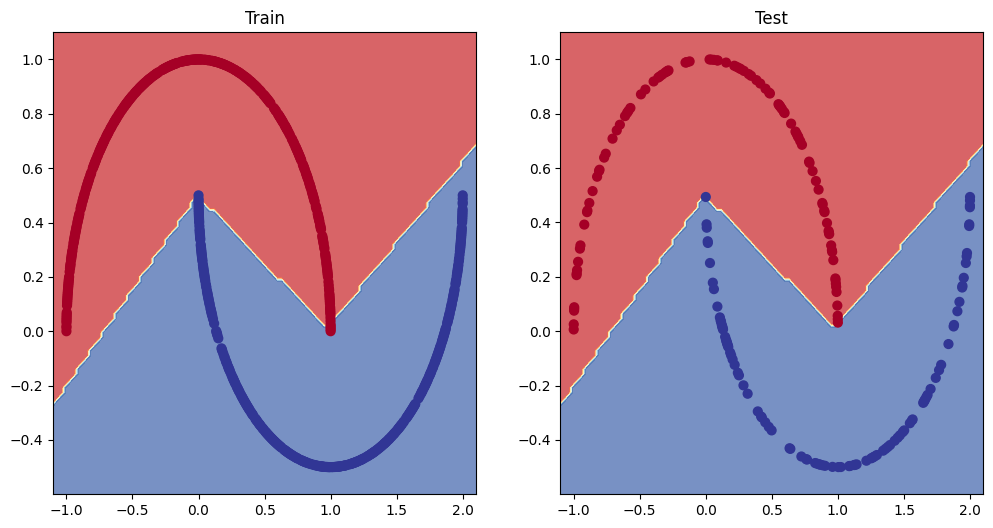

In [88]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_moon, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_moon, X_test, y_test)

In [90]:
def tanh(x):
  return ((torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x)))

A = torch.arange(-10, 10, 1, dtype=torch.float32)
tanh(A), torch.tanh(A)

(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
         -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
          1.0000,  1.0000,  1.0000,  1.0000]),
 tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
         -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
          1.0000,  1.0000,  1.0000,  1.0000]))

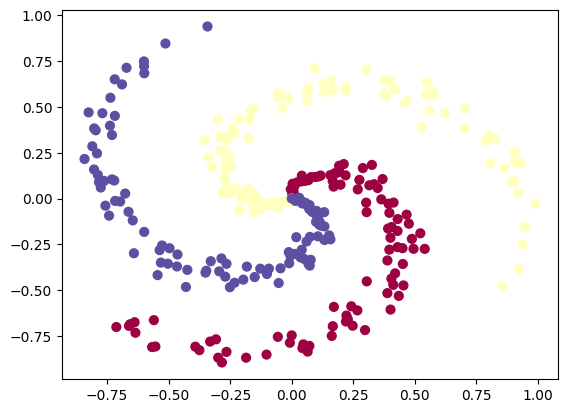

In [96]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [94]:
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=D, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.Linear(in_features=16, out_features=K)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_spiral = SpiralModel()
model_spiral

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [95]:
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_spiral.parameters(), lr=0.01)

In [97]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_spiral.train()

  y_logits = model_spiral(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = lossFunc(y_logits, y_train)
  accuracy = accuracyFunc(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_moon.eval()
  with torch.inference_mode():
    test_logits = model_spiral(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = lossFunc(test_logits, y_test)
    test_accuracy = accuracyFunc(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss:.5f} | Train Accuracy {accuracy:.2f} | Test Loss {test_loss:.5f} | Test Accuracy {test_accuracy:.2f}")

Epoch 0 | Train Loss 1.0835381746292114 | Train Accuracy 46.666666666666664 | Test Loss 1.0596660375595093 | Test Accuracy 48.333333333333336
Epoch 100 | Train Loss 0.15459659695625305 | Train Accuracy 95.83333333333334 | Test Loss 0.13905788958072662 | Test Accuracy 95.0
Epoch 200 | Train Loss 0.05699119344353676 | Train Accuracy 98.33333333333333 | Test Loss 0.04134799912571907 | Test Accuracy 98.33333333333333
Epoch 300 | Train Loss 0.03541996702551842 | Train Accuracy 98.75 | Test Loss 0.02090318873524666 | Test Accuracy 100.0
Epoch 400 | Train Loss 0.027616821229457855 | Train Accuracy 99.16666666666667 | Test Loss 0.014947806484997272 | Test Accuracy 100.0
Epoch 500 | Train Loss 0.02386734075844288 | Train Accuracy 99.16666666666667 | Test Loss 0.01230950653553009 | Test Accuracy 100.0
Epoch 600 | Train Loss 0.021397875621914864 | Train Accuracy 99.16666666666667 | Test Loss 0.00935522560030222 | Test Accuracy 100.0
Epoch 700 | Train Loss 0.019466081634163857 | Train Accuracy 99.

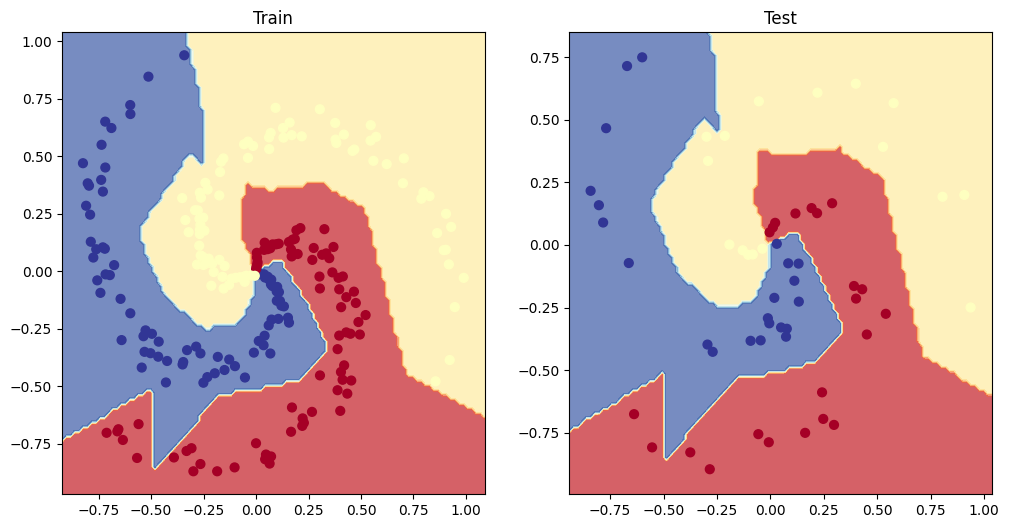

In [98]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_spiral, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_spiral, X_test, y_test)